In [1]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

In [2]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0～1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

100%|██████████| 26.4M/26.4M [00:08<00:00, 3.07MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 109kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.40MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.2MB/s]


In [3]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [4]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [5]:
def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [6]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

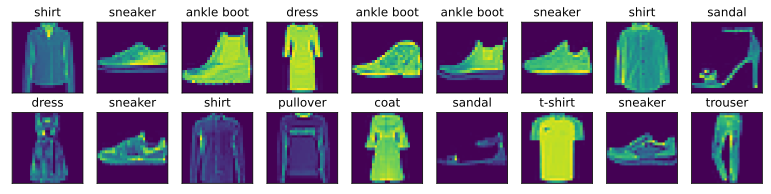

In [27]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18,shuffle=True,)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

In [138]:

batch_size = 1024
import torch.multiprocessing as mp
# Windows 下设置多进程启动方式
mp.set_start_method('spawn', force=True)
def get_dataloader_workers():  #@save
    """使用4个进程来读取数据"""
    return 4
if __name__ == '__main__':
    train_iter = data.DataLoader(
        mnist_train, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=get_dataloader_workers()
    )

    # 计时逻辑也必须放在这个块里面
    timer = d2l.Timer()
    for X, y in train_iter:
        continue
    print(f'{timer.stop():.2f} sec')

5.07 sec


In [ ]:
timer = d2l.Timer()

for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'2.24 sec'

In [86]:
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [88]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


1.会  使用多线程的时候（return 4 batch_size=256）4.85sec——>（return 4 batch_size=1）13.72sec

2. 不够  2.1. window 多线程,不在main的时候（return 4 batch_size=256）4.85sec——>（return 3 batch_size=256）4.81sec 
         2.2. window 多线程,在main的时候  #4.9sec
         if __name__ == '__main__':
            train_iter = data.DataLoader(
            mnist_train, 
            batch_size=batch_size, 
            shuffle=True,
            num_workers=get_dataloader_workers()
            )

            # 计时逻辑也必须放在这个块里面
            timer = d2l.Timer()
            for X, y in train_iter:
            continue
            print(f'{timer.stop():.2f} sec')
         2.3.windo w 单线程的时候（return 0 batch_size=256/512/1024）#2.26sec上下浮动  这个反而更快
          

3. 略